## Analiza realcji między zdarzeniami - wykreślanie trapezów bazujących na średniej i odchyleniu standardowym zdarzeń

### import bibliotek

In [1]:
import pandas as pd
import numpy as np
import pm4py
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime
from matplotlib.patches import Rectangle
from copy import deepcopy

from pm4py import discover_bpmn_inductive
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

### Załadowanie pliku formatu .xes

In [2]:
log = xes_importer.apply('logs/exercise6.xes')

C:\Users\sroka\AppData\Roaming\Python\Python39\site-packages\pm4py\util\dt_parsing\parser.py:76: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/132 [00:00<?, ?it/s]

### Przetworzenie logów do pd.Dataframe

In [3]:
df = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)

### Podgląd logow znajdujących się w załadowanym pliku

In [4]:
df.head()

,org:resource,time:timestamp,concept:name,lifecycle:transition,case:concept:name
0,Call Centre Agent,2005-12-31 23:00:00+00:00,check if sufficient information is available,start,0
1,Call Centre Agent,2006-01-13 23:00:00+00:00,check if sufficient information is available,complete,0
2,Call Centre Agent,2006-01-13 23:00:00+00:00,register claim,start,0
3,Call Centre Agent,2008-01-29 23:00:00+00:00,register claim,complete,0
4,Claims handler,2008-01-29 23:00:00+00:00,determine likelihood of claim,start,0


In [5]:
print(df.groupby(['lifecycle:transition'])['lifecycle:transition'].count())

lifecycle:transition
complete    821
start       821
Name: lifecycle:transition, dtype: int64


### Zamiana logów na format zawierający star_timestamp oraz complete_timestamp

In [6]:
df['start_timestamp'] = df.loc[df['lifecycle:transition'] == 'start', 'time:timestamp']
df['complete_timestamp'] = df.loc[df['lifecycle:transition'] == 'complete', 'time:timestamp']
df.drop(['lifecycle:transition', 'time:timestamp'], axis=1, inplace=True)

In [7]:
df.head()

,org:resource,concept:name,case:concept:name,start_timestamp,complete_timestamp
0,Call Centre Agent,check if sufficient information is available,0,2005-12-31 23:00:00+00:00,NaT
1,Call Centre Agent,check if sufficient information is available,0,NaT,2006-01-13 23:00:00+00:00
2,Call Centre Agent,register claim,0,2006-01-13 23:00:00+00:00,NaT
3,Call Centre Agent,register claim,0,NaT,2008-01-29 23:00:00+00:00
4,Claims handler,determine likelihood of claim,0,2008-01-29 23:00:00+00:00,NaT


In [8]:
# Grupowanie po pierwszych trzech kolumnach
grouped = df.groupby(['org:resource', 'concept:name', 'case:concept:name'], as_index=False)

# Agregowanie wartości start_timestamp i complete_timestamp za pomocą funkcji first i last
df = grouped.agg({'start_timestamp': 'first', 'complete_timestamp': 'last'})

In [9]:
df.head()

,org:resource,concept:name,case:concept:name,start_timestamp,complete_timestamp
0,Call Centre Agent,check if sufficient information is available,0,2005-12-31 23:00:00+00:00,2006-01-13 23:00:00+00:00
1,Call Centre Agent,check if sufficient information is available,1,2005-12-31 23:00:00+00:00,2006-03-07 23:00:00+00:00
2,Call Centre Agent,check if sufficient information is available,10,2006-03-30 23:00:00+00:00,2006-04-09 23:00:00+00:00
3,Call Centre Agent,check if sufficient information is available,100,2008-07-26 23:00:00+00:00,2008-09-16 23:00:00+00:00
4,Call Centre Agent,check if sufficient information is available,101,2007-11-13 23:00:00+00:00,2008-01-19 23:00:00+00:00


In [10]:
df['org:resource'].unique()

array(['Call Centre Agent', 'Claims handler'], dtype=object)

### funkcje

In [11]:
def plot_log_times(df):
    fig, ax = plt.subplots(figsize=(14,6))
    ax.plot(df[['start_timestamp', 'complete_timestamp']], df['case:concept:name'], alpha=0.5, label=['Start_date', 'End_date'])

    plt.legend()
    plt.show()

def plot_only_lines(df: pd.DataFrame, xlim, plot_color: str = 'r'):
    for i in range(df.shape[0] - 1):
        ax.plot([np.array(df['start_timestamp'])[i], np.array(df['complete_timestamp'])[i]], [np.array(df['case:concept:name'])[i],np.array(df['case:concept:name'])[i]], color=plot_color, alpha=0.5)
    ax.get_yaxis().set_visible(False)
    ax.set(xlim=xlim)

# Analiza położenia zadań:

### Analiza 'org:resource' == 'Call Centre Agent'

In [12]:
call_centre_agent = df.loc[df['org:resource'] == 'Call Centre Agent']
print(call_centre_agent['concept:name'].unique())

['check if sufficient information is available' 'end' 'register claim']


In [13]:
check_if_sufficient = call_centre_agent.loc[call_centre_agent['concept:name'] == 'check if sufficient information is available']
register_claim = call_centre_agent.loc[call_centre_agent['concept:name'] == 'register claim']
end = call_centre_agent.loc[call_centre_agent['concept:name'] == 'end']

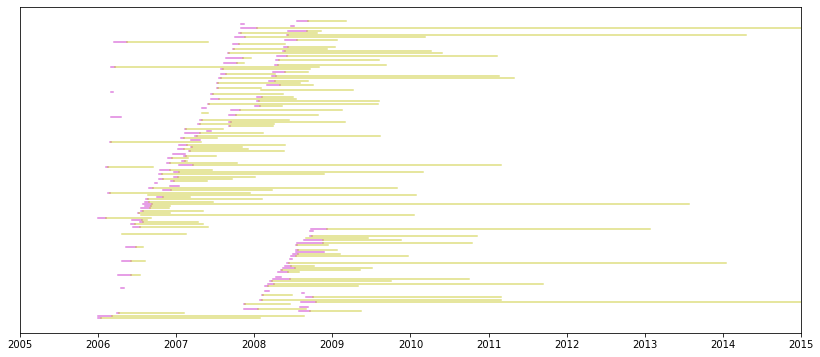

In [14]:
xlim_lower = datetime.strptime('2005-01-01', '%Y-%m-%d')
xlim_upper = datetime.strptime('2015-01-01', '%Y-%m-%d')

fig, ax = plt.subplots(figsize=[14,6])
plot_only_lines(check_if_sufficient, xlim=(xlim_lower, xlim_upper), plot_color='m')
plot_only_lines(register_claim, xlim=(xlim_lower, xlim_upper), plot_color='y')

### Analiza 'org:resource' == 'Claims handler'

In [15]:
claims_handler = df.loc[df['org:resource'] == 'Claims handler']
print(claims_handler['concept:name'].unique())

['advise claimant on reimbursement' 'assess claim' 'close claim'
 'determine likelihood of claim' 'end' 'initiate payment']


In [16]:
assess_claim = claims_handler.loc[claims_handler['concept:name'] == 'assess claim']
close_claim = claims_handler.loc[claims_handler['concept:name'] == 'close claim']
determine_likelihood_of_claim = claims_handler.loc[claims_handler['concept:name'] == 'determine likelihood of claim']
advise_claimant_on_reimbursement = claims_handler.loc[claims_handler['concept:name'] == 'advise claimant on reimbursement']
end = claims_handler.loc[claims_handler['concept:name'] == 'end']

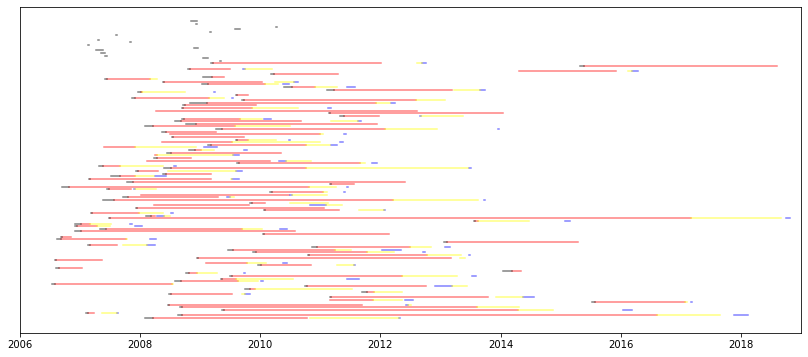

In [17]:
xlim_lower = datetime.strptime('2006-01-01', '%Y-%m-%d')
xlim_upper = datetime.strptime('2019-01-01', '%Y-%m-%d')

fig, ax = plt.subplots(figsize=[14,6])
plot_only_lines(assess_claim, xlim=(xlim_lower, xlim_upper), plot_color='red')
plot_only_lines(close_claim, xlim=(xlim_lower, xlim_upper), plot_color='blue')
plot_only_lines(determine_likelihood_of_claim, xlim=(xlim_lower, xlim_upper), plot_color='black')
plot_only_lines(advise_claimant_on_reimbursement, xlim=(xlim_lower, xlim_upper), plot_color='yellow')

# Wyrówanie czasu między parą zadań

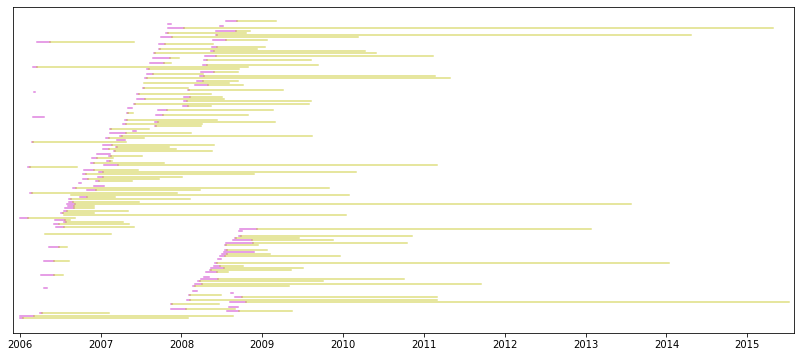

In [78]:
xlim_lower = datetime.strptime('2005-12-01', '%Y-%m-%d')
xlim_upper = datetime.strptime('2015-08-01', '%Y-%m-%d')

fig, ax = plt.subplots(figsize=[14,6])
plot_only_lines(check_if_sufficient, xlim=(xlim_lower, xlim_upper), plot_color='m')
plot_only_lines(register_claim, xlim=(xlim_lower, xlim_upper), plot_color='y')

In [80]:
normalized_call_centre_agent = call_centre_agent.loc[(call_centre_agent['concept:name'] == 'check if sufficient information is available') | (call_centre_agent['concept:name'] == 'register claim')]

In [81]:
left_side = np.min(normalized_call_centre_agent.start_timestamp)
right_side = np.min(normalized_call_centre_agent.complete_timestamp)

In [82]:
normalized_call_centre_agent

,org:resource,concept:name,case:concept:name,start_timestamp,complete_timestamp
0,Call Centre Agent,check if sufficient information is available,0,2005-12-31 23:00:00+00:00,2006-01-13 23:00:00+00:00
1,Call Centre Agent,check if sufficient information is available,1,2005-12-31 23:00:00+00:00,2006-03-07 23:00:00+00:00
2,Call Centre Agent,check if sufficient information is available,10,2006-03-30 23:00:00+00:00,2006-04-09 23:00:00+00:00
3,Call Centre Agent,check if sufficient information is available,100,2008-07-26 23:00:00+00:00,2008-09-16 23:00:00+00:00
4,Call Centre Agent,check if sufficient information is available,101,2007-11-13 23:00:00+00:00,2008-01-19 23:00:00+00:00
...,...,...,...,...,...
259,Call Centre Agent,register claim,93,2007-11-01 23:00:00+00:00,2008-10-19 23:00:00+00:00
260,Call Centre Agent,register claim,94,2008-09-05 23:00:00+00:00,2008-11-06 23:00:00+00:00
261,Call Centre Agent,register claim,95,2008-01-14 23:00:00+00:00,2015-04-26 23:00:00+00:00
262,Call Centre Agent,register claim,98,2008-09-09 23:00:00+00:00,2009-03-04 23:00:00+00:00


In [83]:
df = deepcopy(normalized_call_centre_agent)
task1 = 'check if sufficient information is available'
task2 = 'register claim'

for i in df['case:concept:name'].unique():
    case1 = ((df['case:concept:name'] == i) & (df['concept:name'] == task1))
    case2 = ((df['case:concept:name'] == i) & (df['concept:name'] == task2))
    
    diff = pd.to_datetime(df[case1].start_timestamp) - left_side

    df.loc[case1, 'start_timestamp'] = df.loc[case1, 'start_timestamp'] - diff.item()
    df.loc[case2, 'start_timestamp'] = df.loc[case2, 'start_timestamp'] - diff.item()
    df.loc[case1, 'complete_timestamp'] = df.loc[case1, 'complete_timestamp'] - diff.item()
    df.loc[case2, 'complete_timestamp'] = df.loc[case2, 'complete_timestamp'] - diff.item()

In [84]:
df.head(135)

,org:resource,concept:name,case:concept:name,start_timestamp,complete_timestamp
0,Call Centre Agent,check if sufficient information is available,0,2005-12-31 23:00:00+00:00,2006-01-13 23:00:00+00:00
1,Call Centre Agent,check if sufficient information is available,1,2005-12-31 23:00:00+00:00,2006-03-07 23:00:00+00:00
2,Call Centre Agent,check if sufficient information is available,10,2005-12-31 23:00:00+00:00,2006-01-10 23:00:00+00:00
3,Call Centre Agent,check if sufficient information is available,100,2005-12-31 23:00:00+00:00,2006-02-21 23:00:00+00:00
4,Call Centre Agent,check if sufficient information is available,101,2005-12-31 23:00:00+00:00,2006-03-08 23:00:00+00:00
...,...,...,...,...,...
130,Call Centre Agent,check if sufficient information is available,98,2005-12-31 23:00:00+00:00,2006-02-22 23:00:00+00:00
131,Call Centre Agent,check if sufficient information is available,99,2005-12-31 23:00:00+00:00,2006-01-15 23:00:00+00:00
149,Call Centre Agent,register claim,0,2006-01-13 23:00:00+00:00,2008-01-29 23:00:00+00:00
150,Call Centre Agent,register claim,1,2006-03-07 23:00:00+00:00,2008-08-19 23:00:00+00:00


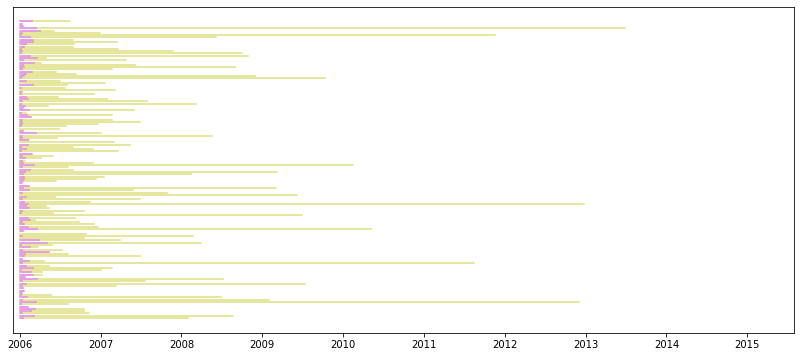

In [86]:
fig, ax = plt.subplots(figsize=[14,6])
plot_only_lines(df.loc[df['concept:name'] == task1], xlim=(xlim_lower, xlim_upper), plot_color='m')
plot_only_lines(df.loc[df['concept:name'] == task2], xlim=(xlim_lower, xlim_upper), plot_color='y')

# Core metody

In [87]:
number_of_traces = df.groupby(['concept:name']).count()
n_task1 = number_of_traces.iloc[0,0]
n_task2 = number_of_traces.iloc[1,0]

In [88]:
mean_start1 = np.mean(df[df['concept:name'] == task1].start_timestamp)
mean_start2 = np.mean(df[df['concept:name'] == task2].start_timestamp)

mean_complete1 = np.mean(df[df['concept:name'] == task1].complete_timestamp)
mean_complete2 = np.mean(df[df['concept:name'] == task2].complete_timestamp)

std_start1 = np.std(df[df['concept:name'] == task1].start_timestamp)
std_start2 = np.std(df[df['concept:name'] == task2].start_timestamp)

std_complete1 = np.std(df[df['concept:name'] == task1].complete_timestamp)
std_complete2 = np.std(df[df['concept:name'] == task2].complete_timestamp)

In [89]:
print(mean_start1,"+-", std_start1)
print(mean_complete1, '+-', std_complete1, end='\n\n')

print(mean_start2, '+-', std_start2)
print(mean_complete2,'+-', std_complete2)

2005-12-31 23:00:00.000000256+00:00 +- 0 days 00:00:00.000000256
2006-01-28 11:10:54.545454848+00:00 +- 25 days 04:48:22.239162298

2006-01-28 07:45:54.782608896+00:00 +- 24 days 09:10:23.898511899
2007-06-22 09:26:05.217391616+00:00 +- 530 days 15:06:50.491031696


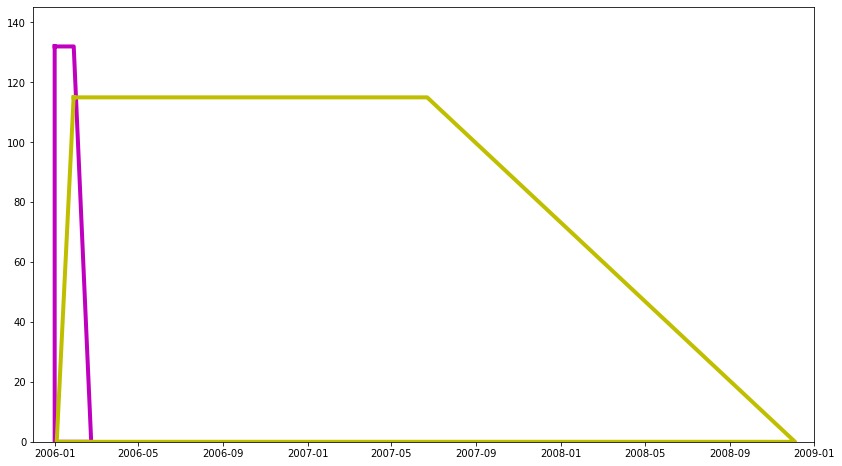

In [90]:
_, ax = plt.subplots(figsize=[14,8])
xlim_lower = datetime.strptime('2005-12-01', '%Y-%m-%d')
xlim_upper = datetime.strptime('2009-01-01', '%Y-%m-%d')

ax.plot([mean_start1, mean_complete1, mean_complete1 + std_complete1, mean_start1-std_start1, mean_start1], [n_task1, n_task1, 0, 0, n_task1], 'm', linewidth=4)
ax.plot([mean_start2, mean_complete2, mean_complete2 + std_complete2, mean_start2-std_start2, mean_start2], [n_task2, n_task2, 0, 0, n_task2], 'y', linewidth=4)
ax.set(xlim=(xlim_lower, xlim_upper), ylim=(0, 1.1*np.max([n_task1,n_task2])))

plt.show()

# Drugi przykład

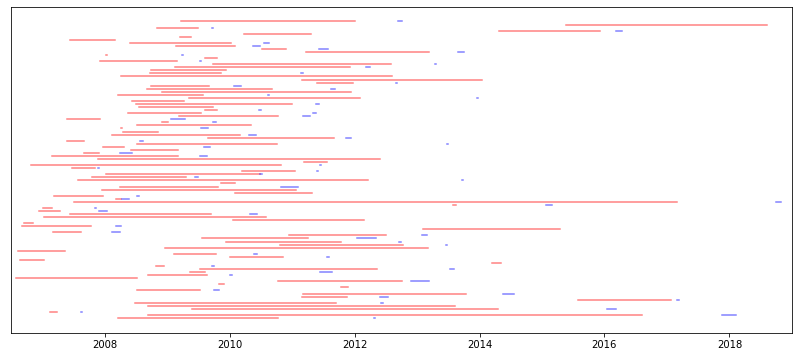

In [57]:
xlim_lower = datetime.strptime('2006-07-01', '%Y-%m-%d')
xlim_upper = datetime.strptime('2019-01-01', '%Y-%m-%d')

fig, ax = plt.subplots(figsize=[14,6])
plot_only_lines(assess_claim, xlim=(xlim_lower, xlim_upper), plot_color='red')
plot_only_lines(close_claim, xlim=(xlim_lower, xlim_upper), plot_color='blue')

In [58]:
normalized_claims_handler = claims_handler.loc[(claims_handler['concept:name'] == 'assess claim') | (claims_handler['concept:name'] == 'close claim')]

In [59]:
left_side = np.min(normalized_claims_handler.start_timestamp)
right_side = np.min(normalized_claims_handler.complete_timestamp)

In [60]:
normalized_claims_handler

,org:resource,concept:name,case:concept:name,start_timestamp,complete_timestamp
340,Claims handler,assess claim,0,2008-03-17 23:00:00+00:00,2010-10-12 23:00:00+00:00
341,Claims handler,assess claim,1,2008-09-11 23:00:00+00:00,2016-08-07 23:00:00+00:00
342,Claims handler,assess claim,10,2007-02-16 23:00:00+00:00,2007-03-29 23:00:00+00:00
343,Claims handler,assess claim,100,2009-05-27 23:00:00+00:00,2014-04-17 23:00:00+00:00
344,Claims handler,assess claim,101,2008-09-12 23:00:00+00:00,2013-08-10 23:00:00+00:00
...,...,...,...,...,...
510,Claims handler,close claim,9,2008-06-19 23:00:00+00:00,2008-06-19 23:00:00+00:00
511,Claims handler,close claim,92,2016-03-07 23:00:00+00:00,2016-04-12 23:00:00+00:00
512,Claims handler,close claim,93,2009-09-19 23:00:00+00:00,2009-09-27 23:00:00+00:00
513,Claims handler,close claim,98,2012-09-12 23:00:00+00:00,2012-10-01 23:00:00+00:00


In [61]:
df = deepcopy(normalized_claims_handler)
task1 = 'assess claim'
task2 = 'close claim'

for i in df['case:concept:name'].unique():
    case1 = ((df['case:concept:name'] == i) & (df['concept:name'] == task1))
    case2 = ((df['case:concept:name'] == i) & (df['concept:name'] == task2))
    
    diff = pd.to_datetime(df[case1].start_timestamp) - left_side

    df.loc[case1, 'start_timestamp'] = df.loc[case1, 'start_timestamp'] - diff.item()
    df.loc[case2, 'start_timestamp'] = df.loc[case2, 'start_timestamp'] - diff.item()
    df.loc[case1, 'complete_timestamp'] = df.loc[case1, 'complete_timestamp'] - diff.item()
    df.loc[case2, 'complete_timestamp'] = df.loc[case2, 'complete_timestamp'] - diff.item()

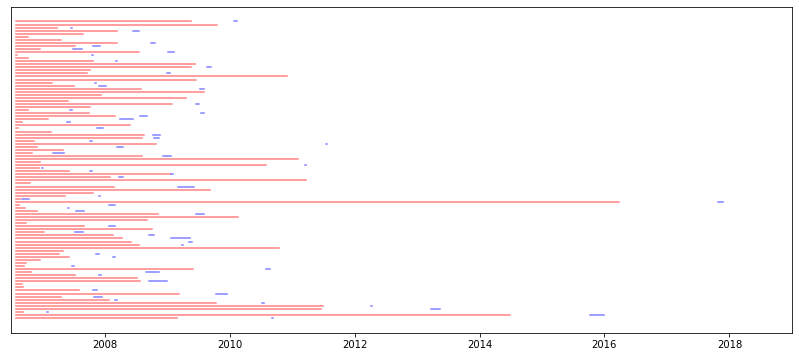

In [67]:
fig, ax = plt.subplots(figsize=[14,6])
plot_only_lines(df.loc[df['concept:name'] == task1], xlim=(xlim_lower, xlim_upper), plot_color='r')
plot_only_lines(df.loc[df['concept:name'] == task2], xlim=(xlim_lower, xlim_upper), plot_color='b')

In [63]:
mean_start1 = np.mean(df[df['concept:name'] == task1].start_timestamp)
mean_start2 = np.mean(df[df['concept:name'] == task2].start_timestamp)

mean_complete1 = np.mean(df[df['concept:name'] == task1].complete_timestamp)
mean_complete2 = np.mean(df[df['concept:name'] == task2].complete_timestamp)

std_start1 = np.std(df[df['concept:name'] == task1].start_timestamp)
std_start2 = np.std(df[df['concept:name'] == task2].start_timestamp)

std_complete1 = np.std(df[df['concept:name'] == task1].complete_timestamp)
std_complete2 = np.std(df[df['concept:name'] == task2].complete_timestamp)

In [64]:
print(mean_start1,"+-", std_start1)
print(mean_complete1, '+-', std_complete1, end='\n\n')

print(mean_start2, '+-', std_start2)
print(mean_complete2,'+-', std_complete2)

number_of_traces = df.groupby(['concept:name']).count()
n_task1 = number_of_traces.iloc[0,0]
n_task2 = number_of_traces.iloc[1,0]

2006-07-31 23:00:00.000000256+00:00 +- 0 days 00:00:00.000000256
2008-03-22 19:36:21.818182144+00:00 +- 590 days 15:55:51.789408144

2008-12-11 03:25:15.789474048+00:00 +- 685 days 21:15:01.870099504
2009-01-05 21:25:15.789474048+00:00 +- 688 days 08:48:47.827564120


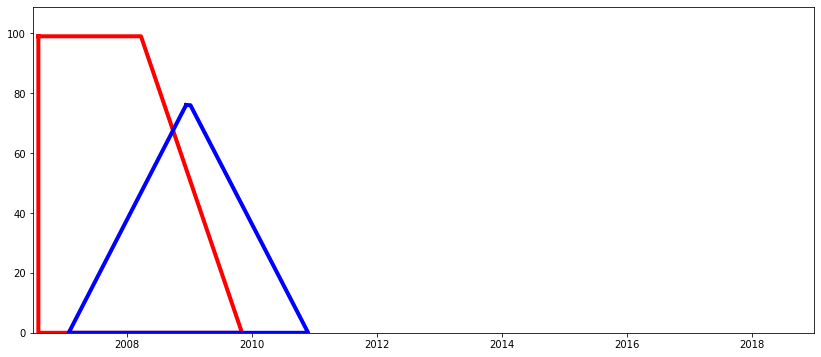

In [66]:
_, ax = plt.subplots(figsize=[14,6])

ax.plot([mean_start1, mean_complete1, mean_complete1 + std_complete1, mean_start1-std_start1, mean_start1], [n_task1, n_task1, 0, 0, n_task1], 'r', linewidth=4)
ax.plot([mean_start2, mean_complete2, mean_complete2 + std_complete2, mean_start2-std_start2, mean_start2], [n_task2, n_task2, 0, 0, n_task2], 'b', linewidth=4)
ax.set(xlim=(xlim_lower, xlim_upper), ylim=(0, 1.1*np.max([n_task1,n_task2])))

plt.show()